# Background and notes:
"Electricity demand patterns matter for valuing electricity supply resources" http://www.eia.gov/todayinenergy/detail.cfm?id=12711
"Case study of daily electricity demand in New England" (shows hourly curve): http://www.eia.gov/todayinenergy/detail.cfm?id=830
hourly_jan01 = requests.get("https://webservices.iso-ne.com/api/v1.1/combinedhourlydemand/day/20140101/location/4008.json", auth=('travisknop@gmail.com', 'Nirvana1'))
Hourly day electricity demand: http://www.iso-ne.com/isoexpress/web/reports/load-and-demand/-/tree/demand-by-zone
NOAA data: http://www7.ncdc.noaa.gov/CDO/cdoselect.cmd
Nat gas pipelines: http://www.eia.gov/pub/oil_gas/natural_gas/analysis_publications/ngpipeline/northeast.html
Common ISO-NE Abbrevs
drtp = demand response threshhold price
lmp = Locational Marginal Pricing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy
import sklearn
import itertools
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import naive_bayes
from sklearn import metrics    
%matplotlib inline

/Users/travisknop/travis_python/.direnv/python-3.5.0/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


## Energy Sources

In [2]:
def load_energy_source():
    energy_source = pd.read_csv("~/travis_python/homework/FINAL/2014_energy_peak_source.csv", header=1)
    energy_source = energy_source.drop(energy_source.columns[14:], axis=1)
    energy_source = energy_source.drop(energy_source.index[:22])
    energy_source = energy_source.set_index("2014")
    energy_source = energy_source.applymap(int)
    energy_source["annual_pct"] = energy_source.Date / 108357
    energy_source.loc["Hydro"] = (energy_source.loc["Hydro:RunRiver&Pondage"] + energy_source.loc["Hydro:Pump Storage"])
    energy_source = energy_source.drop(energy_source.index[-2])
    energy_source = energy_source.drop(energy_source.index[11])
    energy_source = energy_source.drop(energy_source.index[8])
    energy_source = energy_source.drop(energy_source.index[6])
    energy_source = energy_source.drop(energy_source.index[5])
    energy_source = energy_source.sort(columns="annual_pct", ascending=False)
    print(energy_source.index)
    return energy_source

energy_source = load_energy_source()
energy_source

Index(['Total Generation (GWh)', 'Gas', 'Nuclear', 'Hydro', 'Coal', 'Oil/Gas',
       'Wood/Refuse', 'Refuse', 'Wind', 'Oil', 'Landfill Gas', 'Solar',
       'Steam', 'Methane/Refuse'],
      dtype='object', name='2014')


,Date,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,annual_pct
2014,,,,,,,,,,,,,,
Total Generation (GWh),108357,10095,8345,9051,8013,8435,9322,11085,10081,8927,8302,8031,8671,1.000000
Gas,42745,2472,2342,2362,3560,3588,4265,5354,4861,4037,3805,2985,3115,0.394483
Nuclear,36838,3440,3070,3454,2058,2718,3240,3336,3344,3297,2797,2766,3319,0.339969
Hydro,8708,846,614,595,928,1074,723,774,674,411,547,612,911,0.080364
Coal,5055,1067,1161,1239,352,21,42,231,41,62,4,548,286,0.046651
Oil/Gas,4839,952,369,371,379,308,299,607,389,367,316,254,230,0.044658
Wood/Refuse,3965,351,300,351,282,281,320,348,336,315,350,364,366,0.036592
Refuse,2577,213,188,234,186,221,225,218,225,216,222,221,209,0.023782
Wind,1929,211,177,204,190,137,114,114,90,135,185,212,160,0.017802


# Daily Weather Data~~~~~~~~

In [3]:
def to_fahrenheit(temp):
    return (temp * (9 / 5) + 32).round(1)

def load_weather_data():
    weather1 = pd.read_csv("/Users/travisknop/travis_python/homework/FINAL/weather_daily_2011_15.csv")
    weather1 = weather1.drop(weather1.columns[21], axis=1)
    weather1 = weather1.drop(weather1.columns[10:21], axis=1)
    weather1 = weather1.drop(weather1.columns[5:9], axis=1)
    weather1 = weather1.drop(weather1.columns[1], axis=1)
    weather1["Unnamed: 0"] = pd.to_datetime(weather1["Unnamed: 0"])
    weather1.columns = ["date", "highT", "avgT", "lowT", "avgH"]
    weather1 = weather1[pd.notnull(weather1['date'])]
    weather1 = weather1.set_index("date")
    weather1 = weather1.applymap(int)
    weather1["highT"] = weather1['highT'].apply(to_fahrenheit)
    weather1["avgT"] = weather1['avgT'].apply(to_fahrenheit)
    weather1["lowT"] = weather1['lowT'].apply(to_fahrenheit)
    weather1["hdd"] = weather1['avgT'].apply(lambda x: 65-x)
    return weather1

daily_weather = load_weather_data()
daily_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1802 entries, 2011-01-01 to 2015-12-07
Data columns (total 5 columns):
highT    1802 non-null float64
avgT     1802 non-null float64
lowT     1802 non-null float64
avgH     1802 non-null int64
hdd      1802 non-null float64
dtypes: float64(4), int64(1)
memory usage: 84.5 KB


In [4]:
daily_weather.to_csv("weather_daily_clean.csv")

([<matplotlib.patches.Wedge at 0x109728a90>,
  <matplotlib.text.Text at 0x1097847b8>])

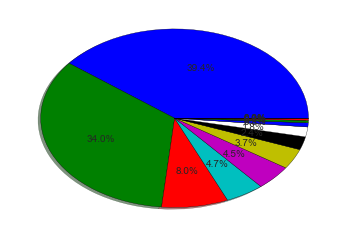

In [5]:
plt.pie(energy_source.Date[1:], autopct='%1.1f%%', shadow=True)

In [6]:
energy_source.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, Total Generation (GWh) to Methane/Refuse
Data columns (total 14 columns):
Date          14 non-null float64
JAN           14 non-null float64
FEB           14 non-null float64
MAR           14 non-null float64
APR           14 non-null float64
MAY           14 non-null float64
JUN           14 non-null float64
JUL           14 non-null float64
AUG           14 non-null float64
SEP           14 non-null float64
OCT           14 non-null float64
NOV           14 non-null float64
DEC           14 non-null float64
annual_pct    14 non-null float64
dtypes: float64(14)
memory usage: 1.6+ KB


# Hourly Electricity

In [7]:
def load_hourly_elec():
    hourlydemand14 = pd.read_csv("~/travis_python/homework/FINAL/Hr_Elec_2011_2015b.csv")
    hourlydemand14 = hourlydemand14.convert_objects(convert_dates='coerce',convert_numeric=True)
    hourlydemand14 = hourlydemand14.drop(hourlydemand14.columns[0], axis=1)
    hourlydemand14 = hourlydemand14.drop(hourlydemand14.columns[1], axis=1)
    hourlydemand14 = hourlydemand14.dropna()
    return hourlydemand14
    

hr_elec = load_hourly_elec()
hr_elec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43368 entries, 0 to 43405
Data columns (total 3 columns):
date    43368 non-null datetime64[ns]
MWHp    43368 non-null float64
MWH     43368 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.3 MB


# Daily Electricity

In [8]:
def convert_elec_hourly_to_daily():
    daily_energy = hr_elec.groupby("date").aggregate(np.sum)
    return daily_energy
    
dy_elec = convert_elec_hourly_to_daily()
dy_elec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1797 entries, 2011-01-01 to 2015-12-02
Data columns (total 2 columns):
MWHp    1797 non-null float64
MWH     1797 non-null float64
dtypes: float64(2)
memory usage: 42.1 KB


# Join Daily Weather and Electricity:

In [9]:
def join_daily_weather_and_elec():
    output = daily_weather.merge(dy_elec, left_index=True, right_index=True)
    return output
    
dy_w_elec = join_daily_weather_and_elec()
dy_w_elec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1797 entries, 2011-01-01 to 2015-12-02
Data columns (total 7 columns):
highT    1797 non-null float64
avgT     1797 non-null float64
lowT     1797 non-null float64
avgH     1797 non-null int64
hdd      1797 non-null float64
MWHp     1797 non-null float64
MWH      1797 non-null float64
dtypes: float64(6), int64(1)
memory usage: 112.3 KB


# Season & Climate

In [14]:
def load_climate():
    output = pd.read_csv("~/travis_python/homework/FINAL/Climate.csv", header=1)
    output["day_of_year"] = output.index
    output["clim_high"] = output["MaxT"].apply(float)
    output["clim_avg"] = output["AveT"].apply(float)
    output["clim_low"] = output["MinT"].apply(float)
    print(output.head())
    output = output.drop(output.columns[:4], axis=1)
    return output

climate = load_climate()
climate.describe()

KeyError: 'MaxT'

In [22]:
def load_climate():
    output = pd.read_csv("~/travis_python/homework/FINAL/Climate.csv")
    output = output.drop(output.columns[0], axis=1)
    output = output.iloc[:1797]
    output = output.set_index(dy_w_elec.index)
    return output

climate = load_climate()
climate.tail()

,day_of_year,clim_high,clim_avg,clim_low
date,,,,
2015-11-28,327,49.3,42.5,35.7
2015-11-29,328,48.9,42.1,35.3
2015-11-30,329,48.5,41.7,34.9
2015-12-01,330,48.2,41.4,34.6
2015-12-02,331,47.8,41.0,34.2


# Add Climate to Daily

In [23]:
def add_climate_daily():
    df = dy_w_elec.merge(climate, left_index=True, right_index=True)
    return df

dwc_elec = add_climate_daily()
dwc_elec.head()

,highT,avgT,lowT,avgH,hdd,MWHp,MWH,day_of_year,clim_high,clim_avg,clim_low
date,,,,,,,,,,,
2011-01-01,55.4,46.4,35.6,73,18.6,37361.3,36901.9,0,37.8,30.7,23.6
2011-01-02,51.8,44.6,37.4,85,20.4,36875.0,37802.5,1,37.6,30.5,23.4
2011-01-03,37.4,33.8,28.4,48,31.2,40222.2,42653.6,2,37.5,30.4,23.3
2011-01-04,39.2,32.0,24.8,52,33.0,45005.6,43458.4,3,37.3,30.2,23.1
2011-01-05,39.2,33.8,28.4,49,31.2,41358.7,43275.3,4,37.2,30.1,22.9


In [ ]:
dy_w_elec.iloc[100:150]